# 一、从数据中学习

要识别一张图像，先从图像中提取特征量，再用机器学习技术学习这些特征量的模式。

何为**特征量**？即：从输入数据（输入图像）中准确地提取**本质数据**（重要的数据）的转换器，通常表示为向量。在计算机视觉领域，常用的特征量包括SIFT、SURF和HOG等。

**将一张图像转换成特征量（向量），然后对转换后的特征量进行机器学习（SVM、KNN等分类器）。**

机器学习的方法中，由机器从收集到的数据中找出规律性。与从零开始想出算法相比，这种方法可以更高效地解决问题，也能减轻人的负担。但是需要注意的是，将图像转换为向量时使用的特征量仍是由人设计的。对于不同的问题，必须使用合适的特征量（必须设计专门的特征量），才能得到好的结果。比如，为了区分狗的脸部，人们需要考虑与用于识别5的特征量不同的其他特征量。也就是说，即使使用特征量和机器学习的方法，也需要针对不同的问题人工考虑合适的特征量。

![image-20230314214816571](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230314214816571.png)

# 二、损失函数

损失函数是表示神经网络性能的“恶劣程度”的指标，即当前的神经网络对监督数据在多大程度上不拟合，在多大程度上不一致。

损失函数可以使用任意函数，但一般用**均方误差**和**交叉熵误差**等。

## 2.1均方误差

![image-20230314215149638](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230314215149638.png)

其中，$y_k$表示神经网络的输出，$t_k$表示监督数据，$k$表示数据的维数。

通俗点讲，$y_k$就是神经网络预测的结果（不一定准确），$t_k$就是标准答案，把结果和标准答案之间求一个误差，从而判断网络的优劣。

如手写数字识别的例子中，$y_k=[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]$，$t_k=[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]$，$k=10$

均方误差代码实现：

In [2]:
import numpy as np


def mean_squared_error(y, t):
    return 0.5*np.sum(np.square(y-t))


## 2.2交叉熵

![image-20230315095953261](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230315095953261.png)

其中，$log$是指以e为底的自然对数。

经过观察该式子可以发现，假如$y_k=[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]$，$t_k=[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]$，由于交叉熵损失函数是标签$t_k$与其对应的输出取对数$log(y_k)$相乘，且分类问题标签中只有若干位是1（有效）其他全是0（无效），所以交叉熵误差的值是由正确解标签所对应的输出结果决定的，在这个例子中就是索引为2的数据，损失值$=-log0.6$。

下图是$log_ex$的函数图像，经过分析发现，$x$越大（即$y_k$（概率）越大），$y$就越大，从而$-logx$就越小：

![image-20230315101559654](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230315101559654.png)

**简而言之，交叉熵就是告诉你，我只要看标准答案对应的输出结果（概率）是多少，如果概率越大，说明输出正确的可能性越大，从而损失值越小。**

交叉熵损失函数代码实现：

In [3]:
def cross_entropy_error(y, label):
    delta = 1e-7
    tmp = -np.sum(np.multiply(np.log(np.add(y, delta)), label))
    return tmp


# 测试
label = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print(cross_entropy_error(y, label))


0.510825457099338


上述代码中加入$delta$的原因是：防止输入为0的时候，出现$log(0)$，计算无法进行。

上面讲的是对于一个输入数据（一张图片）输出的损失函数，那么现在数据集中有N个输入数据，就需要用所有单个损失值求一个总的损失值。方法是：把N个数据的全部损失值求和，再求平均。公式如下：

![image-20230318084906353](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230318084906353.png)

## 2.3mini-batch学习

再MNIST数据集中，训练数据有60000个（有些数据集中数据量会比这大得多），如果将每一个数据都求损失函数并求平均，那计算量将会变得非常大，显然是不现实的。所以就在60000个数据中，随机采取一小部分数据（比如100个）来进行学习。这种学习方法叫做mini-batch方法。

下面来编写从训练数据中随机选择指定个数的数据的代码：

In [4]:
import sys,os

current_file_path = os.path.dirname(os.path.realpath('__file__'))
Demo_path = os.path.join(current_file_path, 'Demo')
sys.path.append(Demo_path)

from dataset.mnist import load_mnist

(x_train, label_train), (x_test, label_test) = load_mnist(
    normalize=True, flatten=True, one_hot_label=True)

#(60000, 784)
#(60000, 10)
#(10000, 784)
#(10000, 10)

# 随机抽取数据
train_size = x_train.shape[0]  # 总数据量
batch_size = 10  # 预抽取数据量
# 返回抽取的10个数对应的源数组x_train的下标
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
label_batch = label_train[batch_mask]


## 2.4mini-batch版的交叉熵损失函数

In [5]:
def cross_entropy_error(y, label):
    if y.ndim == 1:
        y = np.reshape(1, y.size)
        label = np.reshape(1, label.size)

    batch_size = y.shape[0]
    return -np.sum(np.multiply(label, np.log(np.add(y, 1e-7))))/batch_size



上述代码中为什么要先对维度是1的输入数据和标签reshape？因为要和维度大于1的输入数据进行统一，维度为1的数据的shape为(size,)，将其转为(1,size)，方便之后batch_size获取输入数据的条数。



## 2.5损失函数的作用

先来看何为“学习”？学习就是指不断地试错，从试错的结果中吸取教训，之后改变之前的观念和认知的过程。

在机器学习里，整个过程和上述一致。首先要明确**学习的对象是网络的参数（即权重W）**。再看学习的过程：首先随机/任意确定网络的参数，将数据喂入网络得到输出，一开始得到的结果肯定不尽人意（试错）；将得到的结果和标准答案作比较，即计算损失函数（吸取教训）；最后通过损失函数的值判断当前参数是否满意，从而经过某些计算修改网络参数（改变认知）；上述过程重复多次，直至输出正确率符合预期。

关于某些修改网络参数的计算，就是指能够找到使损失函数的值尽可能小的参数的计算。一般为了找到使损失函数尽可能小的地方，就要计算参数的导数，然后以导数为指引，逐步更新参数的值。

假设有一个神经网络，我们要关注网络中某一个权重参数。对**该参数的损失函数求导**，这个步骤的意思是“**如果稍微改变这个权重参数的值，损失函数会如何变化**”。<u>如果导数的值为负（此段函数呈现单调递减），通过使该权重参数向正方向改变，可以减小损失函数的值；反过来，如果导数的值为正（此段函数呈现单调递增），则通过使该权重参数向负方向改变，可以减小损失函数的值。当导数变为0时，权重参数停止更新。</u>

对于参数为二维的情况，上面的导数就称为“方向导数”（表达的意思都是微小变化率，只是称呼不同）。可以很形象的用下面这张图来理解：

![image-20220730104349017](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20220730104349017.png)

上图中，显示了对于两个权重参数$(\theta_0,\theta_1)$取不同的值，对应的损失函数的值。看起来很像起伏的山峰和山谷，而地形的陡峭程度就是方向导数，而我们的目标就是求出红色箭头所指的地方（即损失函数最小点），对应的参数$\theta_0$和$\theta_1$是多少。

假如我们现在在图中的"+"处（即初始点，初始随机参数），想要找到图中的最低点，不可能一下子就确定它的位置，肯定要从"+"处不断摸索，找到当前点处的方向导数下降最快的方向然后移动，而表示导数变化最快的量我们称为“梯度”。所以，找最低点的步骤就归纳为：初始点出发，求梯度，找到方向，移动一小步；循环如上步骤，直到导数为0。

<i>**1. 为什么选择损失函数作为更新参数的衡量标准，而不是识别精度？**</i>

神经网络更新最重要的一点是： **权重参数的连续微小变化能引起损失函数的连续变化。** 举个例子，假设某神经网络在权重$W_1$下对100张手写数字图片进行识别，成功识别20张，识别精度为20%。现在改变$W_1$中某些参数变为$W_2$，仍成功识别20张，那计算导数（变化率）就导致一些区域内的导数为0，导数为0停止更新，这就导致多处神经元死亡。

<i>**2. 为什么使用阶跃函数会导致神经网络停止更新？**</i>

跟上述问题一样，阶跃函数在负区间上输出始终为0；在正区间上，输出始终为1。这就造成无论参数怎么改，只要输入不变号，输出就不变。某些区域导数为0，停止更新。

# 三、数值微分

## 3.1 导数

导数公式：

![image-20230319203710670](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230319203710670.png)

按照该公式写出计算导数的代码：

In [6]:
def numerical_diff(f, x):
    h = 1e-5
    return (f(x+h), f(x))/h

上述代码看似没有问题，但其中引入了一个非常小的量$h$，python中如果数值过于小，就会省略小数中精细的部分，如下：

In [25]:
print(np.float32(1e-46))    # 最小1e-45

0.0


解决这个问题，就将$h$改为$10^{-4}$。

第二个需要改进的地方为：给微小量$h$取值，和对$h$取极限，这两者本身就有误差，前者计算的是两点直线的斜率，后者计算的是某一点的切线斜率。**为了减小这个误差，可以计算函数$f$在$x+h$和$x-h$之间的差分。**

改进后的导数计算算法如下：

In [8]:
def numerical_diff(f,x):
    h=1e-4
    return (f(x+h)-f(x-h))/(2*h)

接下来，用这个函数求个简单的导数

![image-20230319214009223](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230319214009223.png)

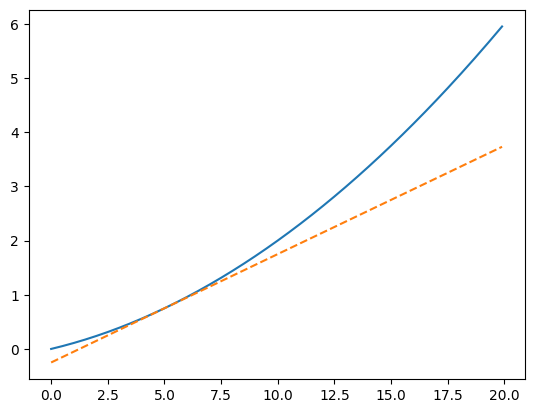

In [9]:
import matplotlib.pyplot as plt

# 确定函数式
def func(x):
    return 0.01*x**2+0.1*x

# 求某点的切线
def tangent_line(f, x):
    gradient = numerical_diff(f, x)  # 切线斜率

    def line(_x):
        return gradient*(_x-x)+f(x)
    
    return line #返回一个函数式

# 画线
x = np.arange(0, 20, 0.1)
y1 = func(x)
tf=tangent_line(func,5)
y2=tf(x)
plt.plot(x,y1)
plt.plot(x,y2,linestyle='--')
plt.show()


## 3.2偏导数

假如现在有如下式子：

![image-20230320103225419](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230320103225419.png)

其中有两个变量，下面用代码实现：

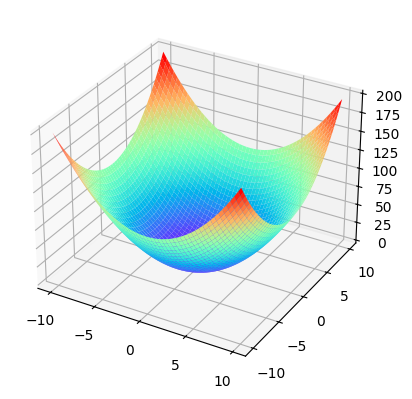

In [10]:
def func(x):
    return x[0]**2+x[1]**2

#设置图像为三维格式
figure=plt.figure()
ax=plt.axes(projection='3d')

#确定输入范围
X1=np.arange(-10,10,0.1)
X2=np.arange(-10,10,0.1)

#绘制网格
X1,X2=np.meshgrid(X1,X2)

#确定表达式
Z=X1**2+X2**2

#画图
ax.plot_surface(X1,X2,Z,cmap='rainbow')
plt.show()


求偏导数：待求变量不动，另一个变量看成常数，再对待求变量求导

比如，当$x_0=3，x_1=4$时，对$x_0$求偏导数如下：


In [11]:
def func_tmp1(x0):
    return x0**2+4**2

print(numerical_diff(func_tmp1,3))

6.00000000000378


## 3.3梯度

求$x_0=3,x_1=4$时，$x_0,x_1$的偏导数为：![image-20230320150135578](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230320150135578.png)

像这样**全部由变量的偏导数汇总而成的向量**称为**梯度**。

梯度的实现如下：

In [12]:
#x是变量的取值，x.size代表变量的个数
def numerical_gradient(f,x):
    h=1e-4
    gradient=np.zeros_like(x) #生成和x一样大小的全零数组

    for i in range(x.size):
        #计算f(x+h)
        #取出其中一个（待求变量）+h，另一个不动
        tmp=x[i]
        x[i]=tmp+h
        f1=f(x)

        #计算f(x-h)
        x[i]=tmp-h
        f2=f(x)

        #求差分
        gradient[i]=(f1-f2)/(2*h)

        #还原
        x[i]=tmp
    
    return gradient

#测试
print(numerical_gradient(func,np.array([3.0,4.0])))
    

[6. 8.]


下图为函数$f(x_0,x_1)=x_0^2+x_1^2$的每个取值点的梯度（一个向量），可以观察发现，每个点的梯度都指向该函数的最低处，且离最低处越远，箭头越大。

![image-20230320204319480](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230320204319480.png)

实际上，梯度会指向各点处函数值降低的方向；**更严格的说，梯度指示的方向是各点处的函数值减小最多的方向**。这一点非常重要，对于如何在一点能够最快的找到局部函数值最低点有着至关重要的作用，也是下面所讲的梯度下降法的基础。

## 3.4梯度法

通过使用梯度来寻找函数最小值的方法就是梯度法。

需要注意的是，梯度表示的是各点处的函数值减小最多的方向。所以，**梯度所指方向不一定是函数值最小值或真正应该前进的方向**。实际上，在复杂的函数中，梯度指示的方向基本上都不是函数值最小处。

虽然梯度的方向并不一定指向最小值，但**沿着它的方向能够最大限度地减小函数的值**。因此，在寻找函数的最小值（或者尽可能小的值）的位置的任务中，要**以梯度的信息为线索**，决定前进的方向。

**梯度法**：函数的取值从当前位置沿着梯度方向前进一定距离，然后在新的地方重新求梯度，再沿着新梯度方向前进，如此反复，不断地沿梯度方向前进，从而逐渐减小函数值。

下面用表达式来表示梯度法：

![image-20230320212036421](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230320212036421.png)

上式中，将一个向量分为两个基向量进行计算，$\eta$为**学习率**，表示了每次朝梯度方向迈出距离的长短。以下图为例：

![image-20220730104349017](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20220730104349017.png)

图中可以看出，有多个极小值/局部最小值（洼地），如果每次步子迈的太大，即学习率$\eta$过大，就可能一步跨过（错过）最小值点，导致一直在找最小值点，模型没办法收敛，这被称为**梯度爆炸**；反之，如果学习率过小，就有可能陷入局部最小值点（极小值点），从而找到的不是全局最小值点。

一般的，在训练中，学习率都要实现确定为某个值，比如0.01或0.001。在神经网络的学习中，一般会一边改变学习率的值，一边确认学习是否正确进行了。

下面用python实现梯度下降法：

In [13]:
def gradient_descent(f,x,lr=0.01,step_num=100):
    for i in range(step_num):
        grad=numerical_gradient(f,x)
        x=x-lr*grad

    return x

尝试用梯度法求如下函数的最小值：

![](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230321125317446.png)

In [14]:
def func(x):
    return x[0]**2 + x[1]**2

print(gradient_descent(func,np.array([-3.0,4.0]),0.1,100))

[-6.11110793e-10  8.14814391e-10]


下图是上述梯度下降法的过程，原点处是最低的地方，函数的取值一点点在向其靠近。

![image-20230321130636218](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230321130636218.png)

- 如果把学习率调小一点，变成0.01，结果就会像下面这样，步子迈的太小，到不了最小值。

![image-20230321130450855](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230321130450855.png)

- 如果学习率太大，调成0.6，就直接跨过最低点。

![image-20230321130556992](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230321130556992.png)

## 3.5神经网络的梯度

假如此时有一个形状为2×3的权重，下面一行是各参数的偏导数：

![image-20230321135158526](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230321135158526.png)

下面以上述神经网络为例，实现一个SimpleNet类：

In [15]:
import numpy as np

# 预先准备：激活函数（softmax），损失函数（cross_entropy_error），梯度计算函数(numerical_gradient)
def softmax(x):
    max = np.max(x)
    tmp = np.sum(np.exp(x-max))
    return np.exp(x-max)/tmp


def cross_entropy_error(y, label):
    if y.ndim == 1:
        y = y.reshape(1, y.size)
        label = label.reshape(1, label.size)

    # 对输入的y进行处理，取batch
    batch_size = y.shape[0]

    # 交叉熵损失计算的是label（one-hot）中为1的那一位对应的输出，所以找出为1的索引
    one_index = np.argmax(label, axiFs=1)

    return -np.sum(np.log(np.add(y[0:batch_size, one_index], 1e-7)))/batch_size


def numerical_gradient(f, W):
    h = 1e-4
    grad = np.zeros_like(W)

    # 求偏导
    # flags=['multi_index']表示追踪iter的下标
    iter = np.nditer(W, flags=['multi_index'], op_flags=['readwrite'])
    while not iter.finished:
        # 获取当前参数的下标
        index = iter.multi_index
        # 保存当前iter的值
        tmp = W[index]
        # 求f(x+h)
        W[index] = tmp+h
        f1 = f(W)
        # 求f(x-h)
        W[index] = tmp-h
        f2 = f(W)
        # 求梯度
        grad[index] = (f1-f2)/(2*h)
        # 还原值
        W[index] = tmp
        # 继续迭代
        iter.iternext()

    return grad


class SimpleNet:
    def __init__(self) -> None:
        self.W = np.random.randn(2, 3)

    # 前向传播
    def predict(self, x):
        z = np.dot(x, self.W)
        y = softmax(z)

        return y

    # 计算损失函数
    def loss(self, y, label):
        return cross_entropy_error(y, label)


# 四、学习算法实现

## 4.1学习算法基本步骤

**1. 选取数据**

从训练数据中随机选出一部分数据，这部分数据称为mini-batch。我们的目标是减小mini-batch的损失函数的值。

**2. 前向传播**

将mini-batch输入网络，根据计算得到输出。

**3. 求梯度**

根据（2）中的输出、标签（标准答案）以及损失函数，计算梯度，得到能够使损失函数降低的方向。

**4. 更新参数**

由（3）中的方向和学习率，更新各个参数值。

**5. 重复前三步**



## 4.2两层神经网络的类TwoLayerNet


In [16]:
import numpy as np


def softmax(x):
    max = np.max(x)
    tmp = np.sum(np.exp(x-max))
    return np.exp(x-max)/tmp


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def cross_entropy_error(y, label):
    if y.ndim == 1:
        y = y.reshape(1, y.size)
        label = label.reshape(1, label.size)

    # 对输入的y进行处理，取batch
    batch_size = y.shape[0]

    # 交叉熵损失计算的是label（one-hot）中为1的那一位对应的输出，所以找出为1的索引
    one_index = label.argmax(axis=1)

    return -np.sum(np.log(np.add(y[0:batch_size, one_index], 1e-7)))/batch_size


def numerical_gradient(f, W):
    h = 1e-4
    grad = np.zeros_like(W)

    # 求偏导
    # flags=['multi_index']表示追踪iter的下标
    iter = np.nditer(W, flags=['multi_index'], op_flags=['readwrite'])
    while not iter.finished:
        # 获取当前参数的下标
        index = iter.multi_index
        # 保存当前iter的值
        tmp = W[index]
        # 求f(x+h)
        W[index] = tmp+h
        f1 = f(W)
        # 求f(x-h)
        W[index] = tmp-h
        f2 = f(W)
        # 求梯度
        grad[index] = (f1-f2)/(2*h)
        # 还原值
        W[index] = tmp
        # 继续迭代
        iter.iternext()

    return grad


class TwoLayerNet:
    # x_size:输入神经元个数；hidden_size中间层神经元个数；y_size输出层神经元个数；weight_init_std
    def __init__(self, x_size, hidden_size, y_size, weight_init_std=0.01) -> None:
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(x_size, hidden_size)  # \表示两行之间是连接在一起的
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
            np.random.randn(hidden_size, y_size)
        self.params['b2'] = np.zeros(y_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1)+b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2)+b2
        y = softmax(a2)

        return y

    def loss(self, x, label):
        y = self.predict(x)
        return cross_entropy_error(y, label)

    def gradient(self, x, label):
        # 找loss和W的关系
        def loss_W(W):
            # 实际上这个loss_W函数的参数W就是给个样子，没什么作用，实际算的就是loss函数
            return self.loss(x, label)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1']) #列表，字典做形参原数据也会改变
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def accuracy(self,x,label):
        y=self.predict(x)
        y=np.argmax(y,axis=1)
        label=np.argmax(label,axis=1)

        return np.sum(y==label)/float(x.shape[0])

net = TwoLayerNet(2, 3, 2)
net.gradient(np.array([1.0, 2.0]), np.array([0, 1]))


{'W1': array([[ 0.00151804, -0.00284742, -0.00213414],
        [ 0.00303608, -0.00569484, -0.00426828]]),
 'b1': array([ 0.00151804, -0.00284742, -0.00213414]),
 'W2': array([[ 0.2517775 , -0.2517775 ],
        [ 0.24797921, -0.24797921],
        [ 0.25181158, -0.25181158]]),
 'b2': array([ 0.49650598, -0.49650598])}

下面解释一下我在看这段代码时的困惑的地方：loss_W(W)中的W没起到实际的作用，为什么在计算梯度函数$numerical\_gradient$中$f(x+h),f(x-h)$（这里的$f$就是$loss\_W$）的值不一样？

因为在这段代码中：

```py
def numerical_gradient(f, W):
    h = 1e-4
    grad = np.zeros_like(W)

    # 求偏导
    # flags=['multi_index']表示追踪iter的下标
    iter = np.nditer(W, flags=['multi_index'], op_flags=['readwrite'])
    while not iter.finished:
        # 获取当前参数的下标
        index = iter.multi_index
        # 保存当前iter的值
        tmp = W[index]
        # 求f(x+h)
        W[index] = tmp+h
        f1 = f(W)
        # 求f(x-h)
        W[index] = tmp-h
        f2 = f(W)
        # 求梯度
        grad[index] = (f1-f2)/(2*h)
        # 还原值
        W[index] = tmp
        # 继续迭代
        iter.iternext()

    return grad
```

$W$数组是作为形参传进来的，

```py
    numerical_gradient(loss_W, self.params['W1'])
```
中的

```py
    self.params['W1']
```

作为形参赋给$W$，**函数中改变数组形参的值，原数组的值也会跟着改变**。

所以，虽然

```py
    f1 = f(W)
```

看似$f1$的取值跟$W$没有关系，但在此之前，神经网络的权重就已经改变了。



## 4.3训练阶段

In [17]:
import numpy as np
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt

# 获取数据集
(x_train, label_train), (x_test, label_test) = load_mnist(
    normalize=True, flatten=True, one_hot_label=True)

# 用列表记录每一轮损失值
loss_list = []

# 设定超参数
learning_rate = 0.1
batch_size = 100
train_size = x_train.shape[0]
iter_num = 100  # 迭代次数

# 建立网络对象
network = TwoLayerNet(x_size=x_train.shape[1], hidden_size=50, y_size=label_train.shape[1])

# 开始训练
for i in range(iter_num):
    # 选取mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    label_batch = label_train[batch_mask]

    # 计算梯度并更新参数
    grad = network.gradient(x_batch, label_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate*grad[key]

    # 追踪每一轮的损失值
    loss = network.loss(x_batch, label_batch)
    loss_list.append(loss)

# 画出损失值的曲线图
time = list(range(1, iter_num+1))
plt.plot(time, loss_list, scalex='times', scaley='loss')
plt.show()


KeyboardInterrupt: 

ps：上述代码跑了65分钟，仅仅100轮，实在太慢，没有特殊需求这部分代码别轻易运行。

## 4.4测试阶段

神经网络的学习中，必须确认是否能够正确识别训练数据以外的其他数据，即确认是否会发生过拟合。

**过拟合是指，虽然训练数据中的数字图像能被正确辨别，但是不在训练数据中的数字图像却无法被识别的现象。** 神经网络学习的最初目标是掌握泛化能力，因此，要评价神经网络的泛化能力，就必须使用不包含在训练数据中的数据。

【注】：**epoch**：一个epoch是指**学习中所有训练数据均被使用过一次时的更新次数**。比如，对于 10000笔训练数据，用大小为 100笔数据的mini-batch进行学习时，重复随机梯度下降法 100次，所有的训练数据就都被“看过”了A。此时，100次就是一个 epoch。（在训练阶段用的是随机mini-batch选取，所以不能保证每一个数据都能被选到。<u>**一般做法是事先将所有训练数据随机打乱，然后按指定的批次大小，按序生成mini-batch。这样每个mini-batch均有一个索引号，比如此例可以是0, 1, 2, ... , 99，然后用索引号可以遍历所有的mini-batch**</u>）

测试阶段要做的事，一般是测试模型的准确度。为测试模型准确度，将训练阶段的代码稍作修改：

In [ ]:
import numpy as np
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt

# 获取数据集
(x_train, label_train), (x_test, label_test) = load_mnist(
    normalize=True, flatten=True, one_hot_label=True)

train_accurate_list = []
test_accurate_list=[]
epoch=[]

# 超参数
train_size = x_train.shape[0]
iter_num = 10000
batch_size = 100
learning_rate = 0.1

# 一个epoch需要计算多少轮
iter_per_epoch = max(train_size/batch_size, 1)  # 如果train_size<batch_size,则需要1轮

network = TwoLayerNet(
    x_size=x_train.shape[1], hidden_size=50, y_size=label_train.shape[1])

for i in range(iter_num):
    # 获取mini-batch
    batch_mask = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[batch_mask]
    label_batch = label_train[batch_mask]

    # 计算梯度并更新
    grad = network.gradient(x_batch, label_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate*grad[key]

    # 如果已经满一个epoch，也就是每iter_per_epoch轮，就计算准确度
    if i%iter_per_epoch ==0:
        epoch.append(i/iter_per_epoch)
        train_accuracy=network.accuracy(x_train,label_train)
        test_accuracy=network.accuracy(x_test,label_test)
        train_accurate_list.append(train_accuracy)
        test_accurate_list.append(test_accuracy)

#画图
plt.plot(epoch,train_accuracy)
plt.plot(epoch,test_accuracy,linesyle='--')
plt.legend(['train_accuracy','test_accuracy'])
plt.show()

上述代码跑起来太费时间，光正向传播就要把10000+(70000/100)*(10000/600)=21666次batch送到网络中计算，之前100轮总共计算了200次batch花了一个小时。